In [1]:
import torch
import pandas as pd
import lstm
from torchinfo import summary
from torchview import draw_graph
import time
import lstm
import json
import torch
import queue
import threading
import numpy as np 
import pandas as pd
import torch.nn as nn
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

from torch.utils.data import DataLoader, TensorDataset, random_split


In [3]:

dataset = torch.load('../../../data/pecan/lstm_weather_dataset.pt')


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
new_val_size = int(0.8 * val_size)
test_size = val_size - new_val_size

generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)
val_dataset, test_dataset = random_split(val_dataset, [new_val_size, test_size], generator=generator)

print(f'Train Dataset size: {len(train_dataset)} \nValidation Dataset size {len(val_dataset)}\nTest Dataset size {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device set to:", device)

model = lstm.LSTM(hidden_size=128, num_layers=5).to(device)
trainer = lstm.Trainer(model, train_loader, val_loader, device, )
start = time.time()

model, train_losses, val_losses = trainer.train()
print(f'training time: {time.time() - start}')
print('\n', '='*100, '\n')
print(summary(model, input_size=(1,32,17)))
print('\n', '='*100, '\n')
model.eval()
preds = []
actual = []
test_activations = []

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to('cuda:0')
        targets = targets.to('cuda:0')
        outputs = model(data)
        preds.extend(outputs.cpu().numpy())  
        actual.extend(targets.cpu().numpy())  
        test_activations.append(model.activations[-1].cpu().numpy())

print(preds)
print('\n', '='*100, '\n')
print(actual)
print('\n', '='*100, '\n')
print(f'Predictions len: {len(preds)}, Targets len: {len(actual)}')


preds = np.array(preds)
actual = np.array(actual)

squared_difs = (preds - actual) ** 2
mse = np.mean(squared_difs)
rmse = np.sqrt(mse)
print(f"The RMSE is: {rmse}")




Train Dataset size: 2020 
Validation Dataset size 404
Test Dataset size 101
Device set to: cuda
Epoch: 0 Train Loss: 3661290.5078125 Validation Loss: 3655942.25
Epoch: 100 Train Loss: 1292812.359375 Validation Loss: 1294325.576923077
Epoch: 200 Train Loss: 196425.38940429688 Validation Loss: 198052.78245192306
Epoch: 300 Train Loss: 20097.79803466797 Validation Loss: 21155.005859375
####################################################################################################
Final Epoch: 347 Train Loss: 20086.142944335938 Validation Loss: 21115.643780048078
training time: 59.92487549781799


Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     --                        --
├─LSTM: 1-1                              [1, 32, 128]              603,648
├─Linear: 1-2                            [1, 1]                    129
Total params: 603,777
Trainable params: 603,777
Non-trainable params: 0
Total mult-adds (M): 19.32
Inpu

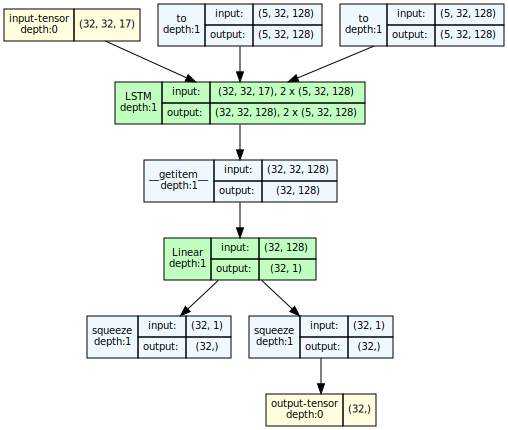

In [3]:
input_dims = (32,32,17)

model_graph = draw_graph(model, input_size=[32, 32,17])
model_graph.visual_graph

In [5]:
import torch.onnx
model = model.to('cpu')
# Export your model to ONNX format
dummy_input = torch.randn(1,32,17)
torch.onnx.export(model, dummy_input, "lstm_model.onnx")
